# 3.2 - Wavelet-Transformation

<img style="float: right; margin:5px 0px 0px 10px" src="img/title.jpg" width="400">
Einführung...

## Inhalt  
<table style="width:256px; border: 1px solid black; display: inline-block">
    <tr>
        <td  style="text-align:right" width=64px><img src="img/1.jpg" style="float:left"></td>
        <td style="text-align:left" width=256px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#1'>
                1. Unzulänglichkeiten der STFT
            </a>
        </td>
    </tr>  
    <tr>
        <td style="text-align:right"><img src="img/2.jpg" style="float:left"></td>
        <td style="text-align:left" width=128px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#2'>
                2. Wavelet-Transformation
            </a>
        </td>
    </tr>
    <tr>
        <td style="text-align:right"><img src="img/3.jpg" style="float:left"></td>
        <td style="text-align:left" width=128px>
            <a style="color:black; font-size:12px; font-weight:bold; text-decoration:none" href='#3'>
                3. Anwendungsbeispiele
            </a>
        </td>
    </tr>
</table>

----

<a id='1'></a>
<div>
    <img src="img/1.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        1. Unzulänglichkeiten der STFT 
    </h2>
</div>

Schauen wir nochmal das Beispiel der STFT in 3.1 und versuchen verschiedene Auflösungen (Zeitfensterlängen):

In [1]:
# Externe Module importieren
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy import fftpack, signal
import librosa
import librosa.display
from IPython.display import clear_output
from scipy.io import wavfile
import IPython.display as ipd

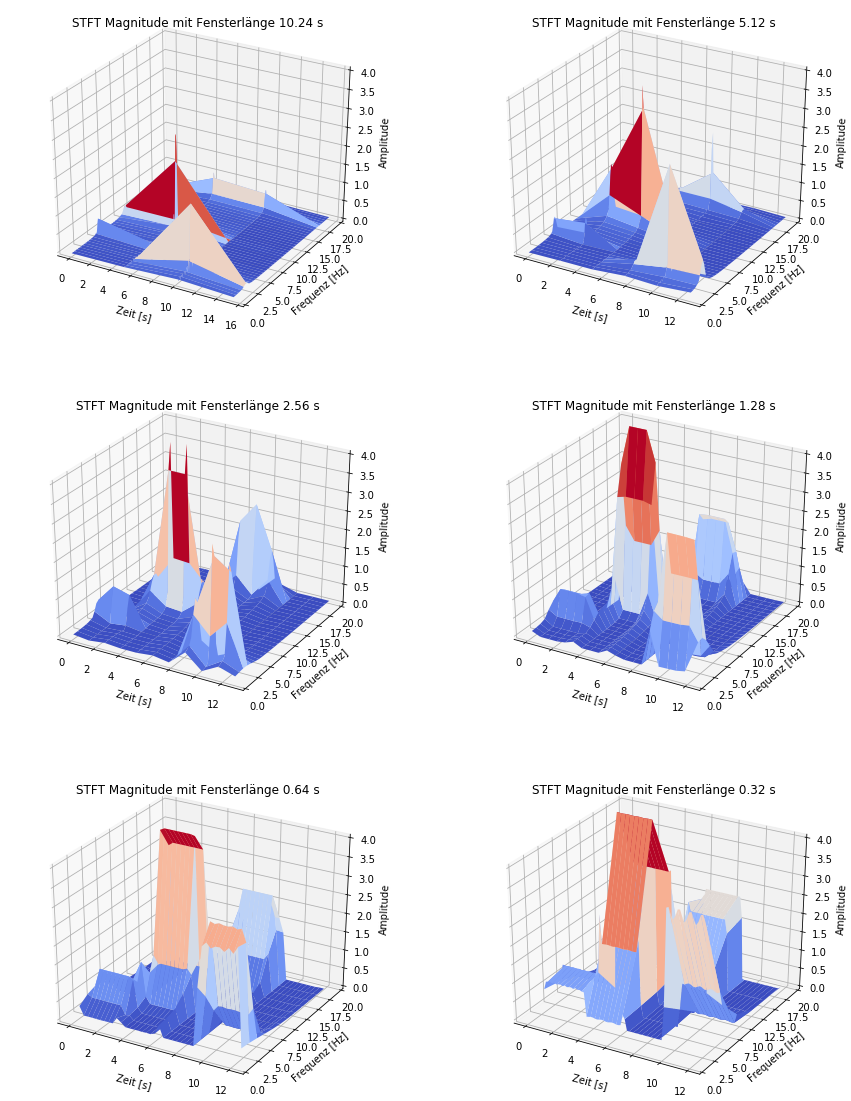

In [87]:
# Initialisierung der Variablen
fs_Hz = 200                            # Abtrastfrequenz
T_s = 12                               # Zeitdauer
L = fs_Hz*T_s                          # Länge des Signals
N = int(2**(np.floor(np.log2(L))+1))   # Länge von FFT
t_s = np.linspace(0, T_s, L)           # Zeitbereich
t4_s = np.linspace(0, T_s/4, L//4)     # Viertelzeitbereich
f_Hz = np.linspace(0, fs_Hz/2, N//2)   # Frequenzbereich

# Signal mit unterschiedlichen Zeitreihen
seg1 = 2 * np.sin(10*np.pi*(t4_s))
seg2 = 10 * np.sin(20*np.pi*t4_s)
seg3 = 5 * np.sin(35*np.pi*t4_s)
seg4 = 7 * np.sin(5*np.pi*t4_s)
s = np.array([seg1, seg2, seg3, seg4]).flatten()

# Spektral durch STFT mit verschiedenen Fensterlängen
fig = plt.figure()
fig.set_size_inches(15, 20)

for i in range(1, 7):
    
    windowLength = N // (2**(i))
    TWindow_s = windowLength/fs_Hz
    f, t, Zxx = signal.stft(s, fs_Hz, nperseg=windowLength)     
    fLimit = (f>0) & (f<20)             
    f = f[fLimit]                        
    Zxx = Zxx[fLimit]
    
    ax = fig.add_subplot(3,2,i, projection='3d')
    ax.set_title('STFT Magnitude mit Fensterlänge %.2f s' %TWindow_s)
    ax.set_xlabel('Zeit [s]') 
    ax.set_ylabel('Frequenz [Hz]')  
    ax.set_zlabel('Amplitude')  
    ax.set_ylim(0, 20)
    ax.set_zlim(0, 4)
    ax.plot_surface(t[None, :], f[:, None], abs(Zxx), cmap=cm.coolwarm) 
#   ax.plot_wireframe(t[None, :], f[:, None], abs(Zxx))     
          
plt.show()

Wir haben anhand des Beispiels gesehen, dass es im Vergleich zu einer spektrografischen Darstellung mit mittlerer Zeitfensterlänge (16 ms) durch Verlängerung bzw. Verkürzung des Zeitfensters möglich ist, mehr spektrale Details (Schmalbandspektrogramm) bzw. mehr zeitliche Details (Breitbandspektrogramm) zu gewinnen. Am besten wäre es, man könnte beide Vorteile in einem Spektrogramm vereinen, und zwar möglichst unter Berücksichtigung der folgenden Gesichtspunkte:
- Bei niedrigen Frequenzen wünscht man sich eine gute Frequenzauflösung. Bei diesen Frequenzen führt auch das Gehör eine schmalbandige Analyse durch (unterhalb 500 Hz beträgt die sog. Frequenzgruppenbreite nur 100 Hz, darüber steigt sie dann etwa logarithmisch an). Die für die Auswertung von Sprache besonders wichtigen ersten beiden Formaten bewegen sich ebenfalls in dem niederfrequenten Teil des Spektrums (bis etwa 2,5 kHz).
- Die höheren Frequenzen enthalten offensichtlich weniger relevante spektrale Information, sodass ihre spektrale Auflösung durch die STFT zu genau erscheint. Das Ohr hat in ihrem Bereich Frequenzgruppenbreiten in der Größenordnung von Kilohertz (vgl. später die Tabelle 5.3). Man würde sich deshalb wünschen, dass in diesem Bereich des Spektrogramms die spektrale Auflösung verringert werden könnte, damit man zugleich von einer deutlich verbesserten zeitlichen Auflösung profitiert.

Überträgt man diese Wünsche auf das Raster eines Spektrogramms, wie es dargestellt wurde, sollte es so modifiziert werden, dass die dargestellten Rechtecke bei tiefen Frequenzen möglichst flach (und damit breit), bei hohen Frequenzen möglichst schmal (und damit hoch) sein sollten. Das ist kein Widerspruch zur Unschärferelation, die nur einen einheitlichen Flächeninhalt der Rechtecke fordert. Trotzdem ist der Wunsch durch die STFT nicht erfüllbar, weil sie nur eine einheitliche Rasterung der Zeit-Frequenz-Ebene zulasst. 

Der Grund dafür ist letztlich in der Konstruktion der Aufbaufunktionen zu suchen. Sie stellen ”gefensterte“ Ausschnitte aus komplexen Exponentialschwingungen dar. Unabhängig von deren Frequenz besitzt die zum  Ausschneiden benutzte Fensterfunktion h stets eine feste Länge, was dazu führt, dass das Spektrum der Aufbaufunktionen auch stets eine konstante absolute Bandbreite hat. Daher müssen wir nach Alternativen zur STFT suchen, um die Wünsche zu erfüllen.


----

<a id='2'></a>
<div>
    <img src="img/2.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        2. Wavelet-Transformation 
    </h2>
</div>

Wie bei der STFT wird eine Fensterfunktion auf das zu untersuchende Signal angewendet. Anstatt allerdings das Fenster zu verschieben und zu modulieren (Verschiebung im Frequenzbereich) (wie bei der STFT), wird das Fenster verschoben und skaliert. Durch die Skalierung ergibt sich wie durch die Modulation ebenfalls eine Frequenzverschiebung, allerdings wird gleichzeitig mit einer Frequenzerhöhung die Zeitdauer („Breite“ im Zeitbereich) des Fensters verringert. Dadurch ergibt sich bei höheren Frequenzen eine bessere zeitliche Auflösung. Bei niedrigen Frequenzen wird die Frequenzauflösung besser, dafür wird die Zeitauflösung schlechter.

----

<a id='3'></a>
<div>
    <img src="img/3.jpg" style="float:left">
    <h2 style="position: relative; top: 6px; left: 6px">
        3. Anwendungsbeispiele 
    </h2>
</div>

Beschreibungen...

----

### References

1. Titelbild von [TITLE]()  
2. [Wavelet-Transformation](https://de.wikipedia.org/wiki/Wavelet-Transformation)
3. Lehrbuch: [Intelligente Signalverarbeitung 1 - Signalanalyse](https://katalog.slub-dresden.de/id/0-1654371521/#detail)  
4. [SOURCE]()